In [1]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity



In [2]:
# --- Setup paths ---
DATA_DIR = Path("/content/drive/MyDrive")
CALIB_DIR = DATA_DIR / "calibration"
GNSS_FILE = DATA_DIR / "gnss.csv"
LIDAR_DIR = DATA_DIR / "lidar"
XBAND_DIR = DATA_DIR / "X_band_radar"
OUTPUT_DIR = DATA_DIR / "synced_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)



In [3]:
# --- Load calibration matrices ---
def load_matrix(path):
    matrix = []
    if not path.exists():
        print(f"⚠️ Calibration file not found: {path}, using identity matrix.")
        return np.eye(4)
    with open(path, 'r') as f:
        for line in f:
            try:
                row = [float(x) for x in line.strip().split()]
                if len(row) == 4:
                    matrix.append(row)
            except ValueError:
                continue
    if len(matrix) == 3:
        matrix.append([0, 0, 0, 1])
    matrix_np = np.array(matrix)
    if matrix_np.shape != (4, 4):
        print(f"⚠️ Unexpected calibration matrix shape: {matrix_np.shape}, using identity.")
        return np.eye(4)
    return matrix_np

T_base2lidar = load_matrix(CALIB_DIR / "Base2lidar.txt")
T_base2xband = load_matrix(CALIB_DIR / "Base2xband.txt")



⚠️ Unexpected calibration matrix shape: (2, 4), using identity.
⚠️ Unexpected calibration matrix shape: (2, 4), using identity.


In [4]:
# --- Index files ---
def index_files_by_timestamp(folder, ext):
    if not folder.exists():
        return {}
    return {int(f.stem): f for f in folder.glob(f"*.{ext}") if f.stem.isdigit()}

lidar_ts = index_files_by_timestamp(LIDAR_DIR, "bin")
xband_ts = index_files_by_timestamp(XBAND_DIR, "png")
print(f"🔎 Found {len(lidar_ts)} LiDAR files and {len(xband_ts)} X-Band files")



🔎 Found 30 LiDAR files and 30 X-Band files


In [5]:
# --- Loaders ---
def load_lidar(file):
    pts = np.fromfile(file, dtype=np.float32).reshape(-1, 4)[:, :3]
    pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_trans = (T_base2lidar @ pts_h.T).T[:, :3]
    return pts_trans

def load_image(file):
    return np.array(Image.open(file).convert("L"))



In [6]:
# --- Feature extractors ---
def extract_lidar_features(pts):
    try:
        mean_xyz = np.mean(pts, axis=0)
        std_xyz = np.std(pts, axis=0)
        max_xyz = np.max(pts, axis=0)
        min_xyz = np.min(pts, axis=0)
        return np.concatenate([mean_xyz, std_xyz, max_xyz, min_xyz])
    except Exception as e:
        print(f"⚠️ LiDAR feature error: {e}")
        return np.zeros(12)

def extract_image_features(img):
    try:
        mean = img.mean()
        std = img.std()
        max_val = img.max()
        min_val = img.min()
        p10, p25, p50, p75, p90, p95 = np.percentile(img, [10, 25, 50, 75, 90, 95])
        # Drop median (p50) or keep it for clarity
        return np.array([mean, std, max_val, min_val, p10, p25, p50, p75, p90, p95, std / mean if mean != 0 else 0, max_val - min_val])
    except Exception as e:
        print(f"⚠️ Image feature error: {e}")
        return np.zeros(12)





In [7]:
# --- GNSS loader ---
if GNSS_FILE.exists():
    gnss_df = pd.read_csv(GNSS_FILE)
    if 'timestamp' in gnss_df.columns:
        gnss_df['timestamp'] = pd.to_numeric(gnss_df['timestamp'], errors='coerce')
        gnss_df = gnss_df.dropna(subset=['timestamp'])

    def get_gnss_for_ts(ts):
        if 'timestamp' not in gnss_df.columns:
            return None
        row = gnss_df.iloc[(gnss_df['timestamp'] - ts).abs().argsort()[:1]]
        return row.to_dict('records')[0] if not row.empty else None
else:
    print(f"⚠️ GNSS file not found: {GNSS_FILE}")
    def get_gnss_for_ts(ts): return None



In [8]:
# --- Synchronization ---
feature_pairs = []
for ts_lidar, lidar_file in lidar_ts.items():
    try:
        lidar_data = load_lidar(lidar_file)
        lidar_feat = extract_lidar_features(lidar_data)
        for ts_x, x_file in xband_ts.items():
            x_feat = extract_image_features(load_image(x_file))
            sim = cosine_similarity([lidar_feat], [x_feat])[0][0]
            feature_pairs.append((sim, ts_lidar, ts_x))
    except Exception as e:
        print(f"⚠️ Feature extraction error: {e}")

feature_pairs.sort(reverse=True)
synced_data, saved_pairs, summary = [], set(), []



In [9]:
# --- Save matched frames ---
for i, (sim, ts_lidar, ts_x) in enumerate(feature_pairs[:30]):
    if (ts_lidar, ts_x) in saved_pairs:
        continue
    try:
        lidar_data = load_lidar(lidar_ts[ts_lidar])
        xband_img = load_image(xband_ts[ts_x])
        gnss_info = get_gnss_for_ts(ts_lidar)

        np.save(OUTPUT_DIR / f"lidar_{i}.npy", lidar_data)
        Image.fromarray(xband_img).save(OUTPUT_DIR / f"xband_{i}.png")
        with open(OUTPUT_DIR / f"gnss_{i}.json", 'w') as f:
            json.dump(gnss_info, f)

        synced_data.append({
            "timestamp": ts_lidar,
            "lidar": lidar_data,
            "xband": xband_img,
            "gnss": gnss_info,
            "similarity_score": sim
        })

        summary.append({
            "index": i,
            "timestamp": ts_lidar,
            "lidar_shape": lidar_data.shape,
            "xband_shape": xband_img.shape,
            "similarity_score": sim,
            "gnss_lat": gnss_info.get("latitude") if gnss_info else None,
            "gnss_lon": gnss_info.get("longitude") if gnss_info else None
        })

        saved_pairs.add((ts_lidar, ts_x))
    except Exception as e:
        print(f"⚠️ Error saving frame {i}: {e}")



In [10]:
# --- Save summary ---
if summary:
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(OUTPUT_DIR / "synced_summary.csv", index=False)
    print(f"\n✅ Synchronized {len(synced_data)} frames saved in: {OUTPUT_DIR}")
    print("\n📊 Summary statistics:")
    print(summary_df.describe(include='all'))




✅ Synchronized 30 frames saved in: /content/drive/MyDrive/synced_output

📊 Summary statistics:
            index     timestamp lidar_shape   xband_shape  similarity_score  \
count   30.000000  3.000000e+01          30            30         30.000000   
unique        NaN           NaN           3             1               NaN   
top           NaN           NaN  (32137, 3)  (2048, 2048)               NaN   
freq          NaN           NaN          12            30               NaN   
mean    14.500000  1.724626e+18         NaN           NaN         -0.042007   
std      8.803408  3.576589e+09         NaN           NaN          0.000024   
min      0.000000  1.724626e+18         NaN           NaN         -0.042038   
25%      7.250000  1.724626e+18         NaN           NaN         -0.042026   
50%     14.500000  1.724626e+18         NaN           NaN         -0.042012   
75%     21.750000  1.724626e+18         NaN           NaN         -0.041994   
max     29.000000  1.724626e+18    


📸 First synchronized sample:
             timestamp lidar_shape   xband_shape  similarity_score  \
0  1724625898214689771  (32137, 3)  (2048, 2048)         -0.041957   

                                           gnss_info  
0  {'rosbag_file': 'S_HONESTMISTAKE_SEAD-CM-2200-...  


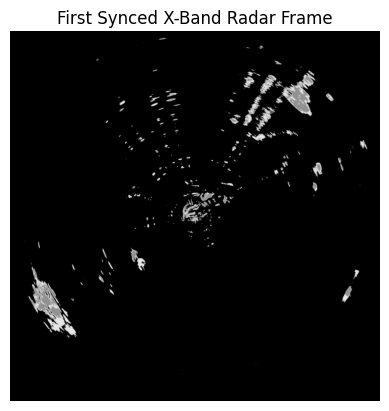

In [11]:
# --- Visualize first sample ---
if synced_data:
    frame = synced_data[0]
    print("\n📸 First synchronized sample:")
    print(pd.DataFrame([{
        "timestamp": frame["timestamp"],
        "lidar_shape": frame["lidar"].shape,
        "xband_shape": frame["xband"].shape,
        "similarity_score": frame["similarity_score"],
        "gnss_info": frame["gnss"]
    }]))
    plt.imshow(frame["xband"], cmap="gray")
    plt.title("First Synced X-Band Radar Frame")
    plt.axis("off")
    plt.show()
